In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
import pandas as pd
import scipy
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from scipy.stats import sem
# import landlab plotting functionality

from pylab import show, figure
from scipy.ndimage import gaussian_filter
from statsmodels.formula.api import ols
from scipy.stats import t
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from scipy.odr import *

In [2]:
location = (r'C:\PhD\manuscript\automated_topographic_thresholds\data\fann');

os.chdir(location);

In [3]:
df1 = pd.read_csv('fann_1.csv')
df2 = pd.read_csv('fann_2.csv')
df3 = pd.read_csv('fann_3.csv')
df4 = pd.read_csv('fann_4.csv')
df5 = pd.read_csv('fann_5.csv')


In [4]:
all_gully_data = df1.append([df2,df3,df4,df5], ignore_index = True)

In [427]:
slope_threshold = 0.001 

In [432]:
all_gully_data = df1.append([df2,df3,df4,df5,df6,df7,df8,
                            df9,df10,df11,df12,df13,df14,df15,
                            df16,df17,df18], ignore_index = True)
forested = df2.append([df3,df4,df5,df9,df11,df12,df13,df14,df15,df17], ignore_index = True)
cleared = df1.append([df6,df7,df8,df10,df16,df18,df19,df20,df21], ignore_index = True)

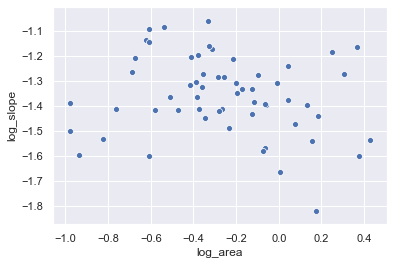

In [5]:
sns.scatterplot(data=all_gully_data, x="log_area", y="log_slope")

In [6]:
def thresholdLineOnlyCooks(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    infl = m.get_influence()
    sm_fr = infl.summary_frame()
    if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
        high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
        corrected_set = regression_dataset.drop(high_value_list, axis='index')
    else:
        corrected_set = regression_dataset
            
    return corrected_set
def linear_func(p, x):
    m, c = p
    return m*x + c

In [8]:
bootstrap_threshold_data = forested

In [436]:
cleared['treecover'] = 'cleared'
forested['treecover'] = 'forested'
plot_both = cleared.append(forested)

In [7]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = all_gully_data
colours = {'forested':'xkcd:forest green', 'cleared':'xkcd:pumpkin'}
x_axis = 'area'
y_axis = 'drainage_slope'

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.7,  edgecolor='xkcd:black', hue = 'treecover', s = 100,
                 style = 'treecover', markers =['o','^'])

ax = fig.axes[0,0]
ax.set_xlim(0.01,100)
ax.set_ylim(0.01,1)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

Div = Line2D([], [], color='xkcd:pumpkin', marker='o', linestyle='None',
                          markersize=15, label='Cleared')
Conv = Line2D([], [], color='xkcd:forest green', marker='o', linestyle='None',
                          markersize=15, label='Forested')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,5)

ValueError: Could not interpret input 'treecover'

In [57]:
n = 10

filtered_data = bootstrap_threshold_data.copy()
for i in range(0,n):
    orthogonal_regression_dataset = thresholdLineOnlyCooks(filtered_data, 'log_area', 'log_slope')
    filtered_data = orthogonal_regression_dataset.copy()
    remaining_data = len(orthogonal_regression_dataset)
    print(len(orthogonal_regression_dataset))

52
48
46
45
45
45
45
45
45
45


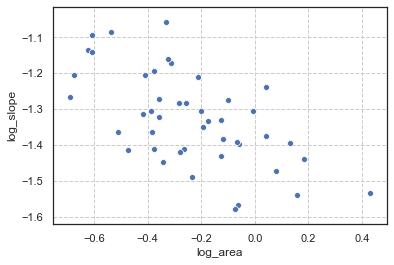

In [58]:
sns.scatterplot(data=orthogonal_regression_dataset, x="log_area", y="log_slope")

In [11]:
#dataset_to_use = orthogonal_regression_dataset
dataset_to_use = bootstrap_threshold_data

In [12]:
slope_area_montecarlo_dict = {}

gully_ids = np.array(dataset_to_use['cp'])
gully_head_list = gully_ids.tolist()
sample_size = 20
whole_dataset = dataset_to_use
cooks_d_cutoff = 4 / sample_size
for i in range(0,1000):
    sample_number = 'Sample' + str(i)
    all_gully_sample = random.sample(gully_head_list, sample_size)
    all_sample_gullies = pd.DataFrame(all_gully_sample)
    all_sample_gullies.rename(columns={0: 'cp'}, inplace=True)
    sample_dataset = pd.merge(all_sample_gullies, whole_dataset, on=['cp'], how='inner')
    #data_for_model = pd.merge(all_sample_gullies, whole_dataset, on=['cp'], how='inner')
    data_for_model = thresholdLineOnlyCooks(sample_dataset, 'log_area', 'log_slope')
    x = data_for_model.loc[:,'log_area'].values
    y = data_for_model.loc[:,'log_slope'].values
    # Create a model for fitting.
    linear_model = Model(linear_func)
    # Create a RealData object using our initiated data from above.
    data = RealData(x, y)
    # Set up ODR with the model and data.
    odr = ODR(data, linear_model, beta0=[-0.4, -1])
    # Run the regression.
    out = odr.run()
    # Use the in-built pprint method to give us results.
    out.pprint()

    exponent_b = out.beta[0] *-1
    coefficient_k = 10**out.beta[1]

    slope_area_montecarlo_dict[sample_number] = ([exponent_b, coefficient_k])

Beta: [-0.05557798 -1.29563305]
Beta Std Error: [0.10346647 0.04134927]
Beta Covariance: [[0.68690153 0.19255715]
 [0.19255715 0.10970616]]
Residual Variance: 0.0155849259156332
Inverse Condition #: 0.2591334211000698
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.47336473 -1.47199417]
Beta Std Error: [0.19491017 0.07543211]
Beta Covariance: [[1.64436826 0.53533704]
 [0.53533704 0.24628765]]
Residual Variance: 0.02310308088960891
Inverse Condition #: 0.1783398704717032
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.36215627 -1.43770244]
Beta Std Error: [0.0978965  0.03458728]
Beta Covariance: [[0.95556734 0.23222437]
 [0.23222437 0.11927784]]
Residual Variance: 0.010029356298476724
Inverse Condition #: 0.2387105112824189
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.09067478 -1.35433189]
Beta Std Error: [0.11774325 0.0572492 ]
Beta Covariance: [[0.81509227 0.329734  ]
 [0.329734   0.19269638]]
Residual Variance: 0.01700847083391283
Inverse 

Beta: [-0.24032417 -1.3857704 ]
Beta Std Error: [0.12436292 0.05687009]
Beta Covariance: [[0.71651936 0.25055411]
 [0.25055411 0.14983524]]
Residual Variance: 0.02158509294786198
Inverse Condition #: 0.2539012245448459
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.45044812 -1.45085107]
Beta Std Error: [0.11528355 0.04580867]
Beta Covariance: [[1.43996045 0.48078856]
 [0.48078856 0.22735851]]
Residual Variance: 0.009229626538525465
Inverse Condition #: 0.18281919290169682
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.09705927 -1.36993289]
Beta Std Error: [0.09442554 0.03444854]
Beta Covariance: [[0.62015389 0.11984961]
 [0.11984961 0.08253956]]
Residual Variance: 0.01437737190371788
Inverse Condition #: 0.3059835767414413
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.00813231 -1.39735542]
Beta Std Error: [0.08597679 0.04175511]
Beta Covariance: [[0.49193119 0.17659203]
 [0.17659203 0.11602755]]
Residual Variance: 0.015026508452247896
Inver

Beta: [-0.17351943 -1.39148938]
Beta Std Error: [0.12379885 0.04284324]
Beta Covariance: [[1.01249438 0.24784103]
 [0.24784103 0.12126181]]
Residual Variance: 0.015137028622199756
Inverse Condition #: 0.22640829666658893
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.39536596 -1.43296983]
Beta Std Error: [0.09674645 0.03492628]
Beta Covariance: [[0.70780403 0.14079418]
 [0.14079418 0.09224604]]
Residual Variance: 0.013223822176100714
Inverse Condition #: 0.29574634969625285
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.05265143 -1.29398545]
Beta Std Error: [0.10073245 0.04708653]
Beta Covariance: [[0.49964389 0.16344009]
 [0.16344009 0.10917297]]
Residual Variance: 0.02030851749357823
Inverse Condition #: 0.2961669884352715
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.46304501 -1.45853371]
Beta Std Error: [0.10237674 0.03634508]
Beta Covariance: [[0.9497227  0.2227203 ]
 [0.2227203  0.11969759]]
Residual Variance: 0.011035850082514053
Inv

Beta: [-0.47500251 -1.4422968 ]
Beta Std Error: [0.09846291 0.03315784]
Beta Covariance: [[0.86418988 0.16077817]
 [0.16077817 0.09800228]]
Residual Variance: 0.011218535013802591
Inverse Condition #: 0.27715396335069886
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.08891723 -1.37052593]
Beta Std Error: [0.09531949 0.02526511]
Beta Covariance: [[1.53829959 0.263336  ]
 [0.263336   0.1080737 ]]
Residual Variance: 0.005906395195624282
Inverse Condition #: 0.19676409917710594
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.09261379 -1.3893478 ]
Beta Std Error: [0.07506609 0.0285727 ]
Beta Covariance: [[0.66444728 0.16939068]
 [0.16939068 0.09626661]]
Residual Variance: 0.008480608528814115
Inverse Condition #: 0.2626356155680153
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.08890313 -1.37507068]
Beta Std Error: [0.09426313 0.04361171]
Beta Covariance: [[0.62524393 0.21589399]
 [0.21589399 0.13383571]]
Residual Variance: 0.014211313536089343
In

Beta: [-0.28259912 -1.37664753]
Beta Std Error: [0.12086394 0.03063774]
Beta Covariance: [[1.04579659 0.06202324]
 [0.06202324 0.06719967]]
Residual Variance: 0.013968387369987238
Inverse Condition #: 0.2720584121476678
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.2415739  -1.42704006]
Beta Std Error: [0.11490586 0.04618887]
Beta Covariance: [[0.75886373 0.21402395]
 [0.21402395 0.12261798]]
Residual Variance: 0.017398849184147972
Inverse Condition #: 0.26033399295760634
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.4071609  -1.43605858]
Beta Std Error: [0.12625611 0.03746697]
Beta Covariance: [[1.04302023 0.16808004]
 [0.16808004 0.09185124]]
Residual Variance: 0.015283121731467552
Inverse Condition #: 0.24918314193249058
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.46628774 -1.45518131]
Beta Std Error: [0.09678202 0.02846964]
Beta Covariance: [[1.17491157 0.1999621 ]
 [0.1999621  0.10166693]]
Residual Variance: 0.007972310325039006
In

Beta: [-0.33101226 -1.43309337]
Beta Std Error: [0.0913758  0.02994142]
Beta Covariance: [[0.96109279 0.19983265]
 [0.19983265 0.1031924 ]]
Residual Variance: 0.008687545150094077
Inverse Condition #: 0.24294063156003315
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.21482688 -1.40595406]
Beta Std Error: [0.14487233 0.04171776]
Beta Covariance: [[1.3118954  0.25781449]
 [0.25781449 0.10878532]]
Residual Variance: 0.015998220128279745
Inverse Condition #: 0.20064572287020008
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.42362135 -1.41546777]
Beta Std Error: [0.11664717 0.03410594]
Beta Covariance: [[1.7661566  0.37964689]
 [0.37964689 0.15098741]]
Residual Variance: 0.007704052188310051
Inverse Condition #: 0.18482643984689606
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.45788863 -1.42112388]
Beta Std Error: [0.07273096 0.02728038]
Beta Covariance: [[0.75974015 0.16476131]
 [0.16476131 0.10688761]]
Residual Variance: 0.0069626336747747606


Beta: [-0.20646726 -1.38676033]
Beta Std Error: [0.11420576 0.03925323]
Beta Covariance: [[0.96097622 0.22395556]
 [0.22395556 0.11352395]]
Residual Variance: 0.01357260901567755
Inverse Condition #: 0.2369135149743184
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.44429894 -1.44106376]
Beta Std Error: [0.10392461 0.0336037 ]
Beta Covariance: [[1.33557177 0.3040156 ]
 [0.3040156  0.13963835]]
Residual Variance: 0.008086667044307872
Inverse Condition #: 0.2145515855174591
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.10521676 -1.4259713 ]
Beta Std Error: [0.11539935 0.04290408]
Beta Covariance: [[0.61946181 0.1350793 ]
 [0.1350793  0.08562586]]
Residual Variance: 0.02149770791582888
Inverse Condition #: 0.29057480688400905
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.1619105  -1.37381731]
Beta Std Error: [0.10290156 0.03861903]
Beta Covariance: [[0.70524111 0.16577665]
 [0.16577665 0.09933367]]
Residual Variance: 0.015014342571305427
Inver

Beta: [-1.03372875e-03 -1.35837903e+00]
Beta Std Error: [0.0863349  0.03721965]
Beta Covariance: [[0.4259931  0.10030275]
 [0.10030275 0.07917253]]
Residual Variance: 0.017497265759356097
Inverse Condition #: 0.348011483335247
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.21010707 -1.34514412]
Beta Std Error: [0.07482784 0.02925427]
Beta Covariance: [[0.62400766 0.15270331]
 [0.15270331 0.09537667]]
Residual Variance: 0.008972976443510266
Inverse Condition #: 0.28769061626626885
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.23068389 -1.36473709]
Beta Std Error: [0.14189051 0.0603524 ]
Beta Covariance: [[1.01334246 0.3507104 ]
 [0.3507104  0.18333214]]
Residual Variance: 0.019867832188251867
Inverse Condition #: 0.2103325251965913
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.33509768 -1.42596495]
Beta Std Error: [0.11867123 0.03244549]
Beta Covariance: [[1.55963974 0.2709373 ]
 [0.2709373  0.11658482]]
Residual Variance: 0.009029560773162

Beta: [ 0.03275033 -1.28843527]
Beta Std Error: [0.10481524 0.04594688]
Beta Covariance: [[0.62335144 0.19999826]
 [0.19999826 0.11978328]]
Residual Variance: 0.01762446361406768
Inverse Condition #: 0.26379015634993647
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.45807934 -1.43798564]
Beta Std Error: [0.12043567 0.04652212]
Beta Covariance: [[1.05055126 0.29986073]
 [0.29986073 0.15675664]]
Residual Variance: 0.013806799516645814
Inverse Condition #: 0.23388859664204972
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.51297089 -1.4490795 ]
Beta Std Error: [0.13477924 0.03917825]
Beta Covariance: [[1.46310378 0.26864377]
 [0.26864377 0.12362869]]
Residual Variance: 0.012415689629563605
Inverse Condition #: 0.2187160975454096
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.12255528 -1.33890789]
Beta Std Error: [0.10672898 0.0494521 ]
Beta Covariance: [[0.40854566 0.1183548 ]
 [0.1183548  0.08770923]]
Residual Variance: 0.02788201162756229
Inve

Beta: [-0.4943418  -1.45732653]
Beta Std Error: [0.23344927 0.07488222]
Beta Covariance: [[2.79629914 0.77449373]
 [0.77449373 0.28771071]]
Residual Variance: 0.019489531924565325
Inverse Condition #: 0.1404979818787412
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.30788734 -1.40211197]
Beta Std Error: [0.11284101 0.04331776]
Beta Covariance: [[0.60674612 0.13171205]
 [0.13171205 0.08941389]]
Residual Variance: 0.02098586867080155
Inverse Condition #: 0.30703531304096315
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.06198433 -1.37308453]
Beta Std Error: [0.1703875 0.0548866]
Beta Covariance: [[0.97148808 0.21588491]
 [0.21588491 0.10080792]]
Residual Variance: 0.029883949353132544
Inverse Condition #: 0.2192288818088789
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.28908188 -1.4073325 ]
Beta Std Error: [0.09701471 0.03655687]
Beta Covariance: [[0.60535806 0.12487014]
 [0.12487014 0.08595582]]
Residual Variance: 0.015547581141188
Inverse C

Beta: [-0.22844519 -1.41617158]
Beta Std Error: [0.10143197 0.04401918]
Beta Covariance: [[0.60393614 0.17695748]
 [0.17695748 0.11374314]]
Residual Variance: 0.017035649325339835
Inverse Condition #: 0.2910438699521922
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.42132864 -1.44232897]
Beta Std Error: [0.10060353 0.03566202]
Beta Covariance: [[0.96580887 0.23948947]
 [0.23948947 0.12136034]]
Residual Variance: 0.010479371231230352
Inverse Condition #: 0.2345213918340767
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.20858965 -1.39047408]
Beta Std Error: [0.1300962 0.0478645]
Beta Covariance: [[1.11371777 0.32145556]
 [0.32145556 0.15075541]]
Residual Variance: 0.01519686728440869
Inverse Condition #: 0.2020623571004939
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.04008245 -1.31169123]
Beta Std Error: [0.11378054 0.03508375]
Beta Covariance: [[1.41846333 0.32016004]
 [0.32016004 0.13486344]]
Residual Variance: 0.009126786480420675
Inverse

Beta: [-0.05953271 -1.38895788]
Beta Std Error: [0.06071584 0.02433382]
Beta Covariance: [[0.4926432  0.10731961]
 [0.10731961 0.07913144]]
Residual Variance: 0.007482927709960897
Inverse Condition #: 0.3275431490266443
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.12828777 -1.3824322 ]
Beta Std Error: [0.11148158 0.05741289]
Beta Covariance: [[0.81294449 0.35591227]
 [0.35591227 0.21561229]]
Residual Variance: 0.01528781299828918
Inverse Condition #: 0.21649601912910532
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.07262473 -1.33780588]
Beta Std Error: [0.13149434 0.04326351]
Beta Covariance: [[0.67143035 0.1152236 ]
 [0.1152236  0.0726826 ]]
Residual Variance: 0.02575212893751898
Inverse Condition #: 0.28087997041654145
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.29412782 -1.43636124]
Beta Std Error: [0.09897707 0.03622456]
Beta Covariance: [[0.76526744 0.18623376]
 [0.18623376 0.10250624]]
Residual Variance: 0.01280135557683485
Inver

Beta: [-0.35894853 -1.45076051]
Beta Std Error: [0.13422966 0.04424759]
Beta Covariance: [[1.07744964 0.24202498]
 [0.24202498 0.11707905]]
Residual Variance: 0.01672245300804625
Inverse Condition #: 0.22700617196254114
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.36377167 -1.42346646]
Beta Std Error: [0.10818501 0.03699886]
Beta Covariance: [[1.04425431 0.24869936]
 [0.24869936 0.1221374 ]]
Residual Variance: 0.011207994132675765
Inverse Condition #: 0.22854505790651924
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.13208455 -1.33179598]
Beta Std Error: [0.09972334 0.0371617 ]
Beta Covariance: [[0.84632647 0.22093717]
 [0.22093717 0.11752638]]
Residual Variance: 0.01175048325334093
Inverse Condition #: 0.24447411410874534
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.1558866  -1.30551542]
Beta Std Error: [0.09919715 0.0356593 ]
Beta Covariance: [[0.67509253 0.13497434]
 [0.13497434 0.08723899]]
Residual Variance: 0.01457589060220287
Inve

Beta: [-0.32935055 -1.39229347]
Beta Std Error: [0.07295237 0.02531696]
Beta Covariance: [[0.77795488 0.16583459]
 [0.16583459 0.09369115]]
Residual Variance: 0.006841075623738982
Inverse Condition #: 0.2632683182160672
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.19442217 -1.33116565]
Beta Std Error: [0.09122566 0.03482238]
Beta Covariance: [[0.45221509 0.07139022]
 [0.07139022 0.06589128]]
Residual Variance: 0.01840301428647825
Inverse Condition #: 0.35799775953566876
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.29026404 -1.41678899]
Beta Std Error: [0.1084921  0.04272852]
Beta Covariance: [[0.6983535  0.18324986]
 [0.18324986 0.10832156]]
Residual Variance: 0.016854695411896686
Inverse Condition #: 0.27204451701244287
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.07066305 -1.37692012]
Beta Std Error: [0.12308833 0.03727148]
Beta Covariance: [[1.32314955 0.27823246]
 [0.27823246 0.12131893]]
Residual Variance: 0.011450509729867175
Inv

Beta: [-0.22521527 -1.33464016]
Beta Std Error: [0.10686824 0.04045533]
Beta Covariance: [[0.63578311 0.14426703]
 [0.14426703 0.09110941]]
Residual Variance: 0.017963391273790878
Inverse Condition #: 0.2902566980987817
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.07816798 -1.33011206]
Beta Std Error: [0.13879491 0.04599439]
Beta Covariance: [[1.04811403 0.24910323]
 [0.24910323 0.1150989 ]]
Residual Variance: 0.018379706049184753
Inverse Condition #: 0.21395124066541338
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.24156301 -1.34013187]
Beta Std Error: [0.13494934 0.04402224]
Beta Covariance: [[1.19205523 0.2774934 ]
 [0.2774934  0.12685254]]
Residual Variance: 0.015277248462757641
Inverse Condition #: 0.2124407222133132
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.10473192 -1.42719851]
Beta Std Error: [0.09487673 0.04723588]
Beta Covariance: [[0.51587411 0.19232981]
 [0.19232981 0.12786994]]
Residual Variance: 0.017449204965756488
Inv

Beta: [-0.14195433 -1.3342168 ]
Beta Std Error: [0.10156324 0.04399567]
Beta Covariance: [[0.5405857  0.15556208]
 [0.15556208 0.1014405 ]]
Residual Variance: 0.01908132390361748
Inverse Condition #: 0.2959458330052715
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.30220695 -1.39905309]
Beta Std Error: [0.13225535 0.0531206 ]
Beta Covariance: [[1.15704243 0.37642394]
 [0.37642394 0.18665889]]
Residual Variance: 0.01511740417711981
Inverse Condition #: 0.2029049238400665
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.01743263 -1.36059517]
Beta Std Error: [0.06835506 0.02632777]
Beta Covariance: [[0.74038078 0.18716857]
 [0.18716857 0.10983528]]
Residual Variance: 0.006310826569323385
Inverse Condition #: 0.2711635273597926
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.21889867 -1.42230164]
Beta Std Error: [0.07954376 0.02876786]
Beta Covariance: [[0.64955904 0.13180158]
 [0.13180158 0.08496138]]
Residual Variance: 0.009740775773540527
Invers

Beta: [-0.23570137 -1.4361298 ]
Beta Std Error: [0.09741867 0.03574573]
Beta Covariance: [[0.75887351 0.1817527 ]
 [0.1817527  0.10217232]]
Residual Variance: 0.012505900273985687
Inverse Condition #: 0.2614188809127417
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.04984813 -1.32825307]
Beta Std Error: [0.08963288 0.03985307]
Beta Covariance: [[0.43382714 0.11965391]
 [0.11965391 0.08576412]]
Residual Variance: 0.018519020897589587
Inverse Condition #: 0.32386945235334735
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.39326949 -1.42818198]
Beta Std Error: [0.10801693 0.03446921]
Beta Covariance: [[1.53289708 0.37542942]
 [0.37542942 0.1560961 ]]
Residual Variance: 0.007611507191553157
Inverse Condition #: 0.1862930352724428
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.32821024 -1.38420164]
Beta Std Error: [0.10398723 0.03967179]
Beta Covariance: [[0.88175218 0.2426889 ]
 [0.2426889  0.12833648]]
Residual Variance: 0.012263472879485187
Inv

Beta: [-0.24650188 -1.40830813]
Beta Std Error: [0.09626723 0.04065057]
Beta Covariance: [[0.57539393 0.15208979]
 [0.15208979 0.10259865]]
Residual Variance: 0.016106149368784368
Inverse Condition #: 0.3074450443570758
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.06019026 -1.4064073 ]
Beta Std Error: [0.08415649 0.04204947]
Beta Covariance: [[0.397578   0.13151178]
 [0.13151178 0.0992586 ]]
Residual Variance: 0.017813649274299907
Inverse Condition #: 0.3341332793734457
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.16478224 -1.33533516]
Beta Std Error: [0.08222684 0.03834183]
Beta Covariance: [[0.39077199 0.10989393]
 [0.10989393 0.08496536]]
Residual Variance: 0.0173022974377997
Inverse Condition #: 0.34546705182140475
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.2549279  -1.37326276]
Beta Std Error: [0.12833664 0.04882215]
Beta Covariance: [[1.12958162 0.34325639]
 [0.34325639 0.1634745 ]]
Residual Variance: 0.01458087879837817
Invers

Beta: [-0.24879976 -1.40375384]
Beta Std Error: [0.06380925 0.02686095]
Beta Covariance: [[0.48593395 0.10719108]
 [0.10719108 0.08610982]]
Residual Variance: 0.008378958856562844
Inverse Condition #: 0.3498353820208043
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.28436568 -1.39242701]
Beta Std Error: [0.09987359 0.03271237]
Beta Covariance: [[1.19989447 0.27958521]
 [0.27958521 0.12872585]]
Residual Variance: 0.008313009115989188
Inverse Condition #: 0.21408304719165913
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.01151144 -1.2888069 ]
Beta Std Error: [0.07611489 0.03361058]
Beta Covariance: [[0.43164854 0.11665898]
 [0.11665898 0.08416725]]
Residual Variance: 0.013421745016302037
Inverse Condition #: 0.3258604928663011
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.1765664  -1.38486434]
Beta Std Error: [0.11291312 0.03269007]
Beta Covariance: [[1.559031   0.32132792]
 [0.32132792 0.13067656]]
Residual Variance: 0.008177754353456678
Inv

Beta: [-0.38949738 -1.39719022]
Beta Std Error: [0.12520306 0.04466181]
Beta Covariance: [[1.72924018 0.51317363]
 [0.51317363 0.22003823]]
Residual Variance: 0.009065140508171437
Inverse Condition #: 0.17192894483358376
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.513756   -1.47042891]
Beta Std Error: [0.12379143 0.04121915]
Beta Covariance: [[1.68980321 0.43697571]
 [0.43697571 0.18734975]]
Residual Variance: 0.009068699414702397
Inverse Condition #: 0.18918288050945467
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.12843604 -1.31901766]
Beta Std Error: [0.09270298 0.03543181]
Beta Covariance: [[0.76196622 0.20987989]
 [0.20987989 0.11131017]]
Residual Variance: 0.011278509521182489
Inverse Condition #: 0.24053203428349162
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.36134812 -1.40003927]
Beta Std Error: [0.10612717 0.04399958]
Beta Covariance: [[1.3380162  0.46171688]
 [0.46171688 0.22998805]]
Residual Variance: 0.008417667546409328
I

Beta: [-0.128336   -1.35804053]
Beta Std Error: [0.11567076 0.03982796]
Beta Covariance: [[1.49505401 0.41905284]
 [0.41905284 0.17724984]]
Residual Variance: 0.00894932581602059
Inverse Condition #: 0.1762988676606998
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.39722561 -1.42430637]
Beta Std Error: [0.12741121 0.04556436]
Beta Covariance: [[0.88357459 0.20739094]
 [0.20739094 0.11299999]]
Residual Variance: 0.018372661810219713
Inverse Condition #: 0.25413432841954264
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.00229489 -1.35741825]
Beta Std Error: [0.08864123 0.03246175]
Beta Covariance: [[1.24803616 0.36178952]
 [0.36178952 0.16737843]]
Residual Variance: 0.006295705786898882
Inverse Condition #: 0.19764076835619138
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.09544328 -1.33263313]
Beta Std Error: [0.08531696 0.04173966]
Beta Covariance: [[0.54628293 0.2019937 ]
 [0.2019937  0.13075087]]
Residual Variance: 0.013324567912293096
Inv

Beta: [ 0.0305294  -1.38312783]
Beta Std Error: [0.08375796 0.03741543]
Beta Covariance: [[0.55495496 0.17491853]
 [0.17491853 0.11074063]]
Residual Variance: 0.012641378917895086
Inverse Condition #: 0.28226178074290825
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.3417965  -1.48758052]
Beta Std Error: [0.11964965 0.05273574]
Beta Covariance: [[0.8959703  0.31158431]
 [0.31158431 0.17405272]]
Residual Variance: 0.015978251680761824
Inverse Condition #: 0.23191747457858705
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.10826692 -1.35532343]
Beta Std Error: [0.08064783 0.03538108]
Beta Covariance: [[0.3126144  0.04650963]
 [0.04650963 0.06016804]]
Residual Variance: 0.020805413943344765
Inverse Condition #: 0.4325103017294945
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.05638464 -1.30656473]
Beta Std Error: [0.08880504 0.03884131]
Beta Covariance: [[0.62181716 0.19306271]
 [0.19306271 0.11895294]]
Residual Variance: 0.012682722197151223
In

Beta: [-0.03298192 -1.35514961]
Beta Std Error: [0.09464214 0.03815357]
Beta Covariance: [[0.52454343 0.12467201]
 [0.12467201 0.08524768]]
Residual Variance: 0.017076059947867032
Inverse Condition #: 0.31079228406323217
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.13631887 -1.37052748]
Beta Std Error: [0.09952442 0.02803961]
Beta Covariance: [[0.91780012 0.12217132]
 [0.12217132 0.07285055]]
Residual Variance: 0.010792229924885169
Inverse Condition #: 0.25491592822486725
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.45243707 -1.45285815]
Beta Std Error: [0.12695848 0.04360419]
Beta Covariance: [[1.46571164 0.39410262]
 [0.39410262 0.17289462]]
Residual Variance: 0.010997017298038762
Inverse Condition #: 0.19134017839957448
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.43365277 -1.43264497]
Beta Std Error: [0.18287087 0.06697   ]
Beta Covariance: [[3.22169142 1.08020864]
 [1.08020864 0.43207132]]
Residual Variance: 0.010380185631388084
I

Beta: [ 0.12610321 -1.32020244]
Beta Std Error: [0.0709123  0.03675159]
Beta Covariance: [[0.39481443 0.1440802 ]
 [0.1440802  0.10604792]]
Residual Variance: 0.012736501318755939
Inverse Condition #: 0.31910859273471814
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.52425952 -1.4225455 ]
Beta Std Error: [0.1671176  0.04952321]
Beta Covariance: [[1.91406839 0.41136152]
 [0.41136152 0.16808567]]
Residual Variance: 0.014591063524130489
Inverse Condition #: 0.1907590661220386
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.21251114 -1.3830593 ]
Beta Std Error: [0.13292644 0.05516805]
Beta Covariance: [[0.81010728 0.25146769]
 [0.25146769 0.13953884]]
Residual Variance: 0.021811232506264933
Inverse Condition #: 0.24365350770283511
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.06472311 -1.28830891]
Beta Std Error: [0.08683297 0.03637161]
Beta Covariance: [[0.62248842 0.18731267]
 [0.18731267 0.10921622]]
Residual Variance: 0.012112618414772725
In

Residual Variance: 0.01062831711889151
Inverse Condition #: 0.1788540848473259
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.37874325 -1.38279161]
Beta Std Error: [0.0936375  0.03160081]
Beta Covariance: [[0.78714556 0.13275281]
 [0.13275281 0.0896503 ]]
Residual Variance: 0.011138959191305007
Inverse Condition #: 0.29428679456819834
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.1058584  -1.33075956]
Beta Std Error: [0.10125105 0.03646246]
Beta Covariance: [[0.54866852 0.09064827]
 [0.09064827 0.07115458]]
Residual Variance: 0.018684825879791526
Inverse Condition #: 0.3254812571754545
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.17109891 -1.28246303]
Beta Std Error: [0.07934823 0.04197189]
Beta Covariance: [[0.32071184 0.11078698]
 [0.11078698 0.0897341 ]]
Residual Variance: 0.019631771333671624
Inverse Condition #: 0.35491778699303245
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.41657621 -1.37512087]
Beta Std Error: [0.

Beta: [-0.25310715 -1.44699384]
Beta Std Error: [0.11599531 0.04851584]
Beta Covariance: [[0.62305296 0.18170677]
 [0.18170677 0.10899618]]
Residual Variance: 0.021595132706182157
Inverse Condition #: 0.27137156971160425
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.07786847 -1.33951013]
Beta Std Error: [0.09454702 0.03875238]
Beta Covariance: [[0.82645448 0.25055894]
 [0.25055894 0.13884175]]
Residual Variance: 0.010816251441672309
Inverse Condition #: 0.24546461023336275
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.01195566 -1.41001145]
Beta Std Error: [0.07874035 0.03419606]
Beta Covariance: [[0.50556686 0.13588236]
 [0.13588236 0.09535335]]
Residual Variance: 0.012263545933775244
Inverse Condition #: 0.31815397544768254
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.13756869 -1.37501208]
Beta Std Error: [0.09044918 0.03782433]
Beta Covariance: [[0.64405043 0.18995134]
 [0.18995134 0.11262976]]
Residual Variance: 0.012702505763247008
I

Inverse Condition #: 0.2463842431501757
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.11665197 -1.40578916]
Beta Std Error: [0.0716515  0.02656897]
Beta Covariance: [[0.61529015 0.13867303]
 [0.13867303 0.08460167]]
Residual Variance: 0.008343929688679941
Inverse Condition #: 0.2817692845221495
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.18795878 -1.24700134]
Beta Std Error: [0.09271184 0.04281193]
Beta Covariance: [[0.60689712 0.20390844]
 [0.20390844 0.12941189]]
Residual Variance: 0.014163003387646587
Inverse Condition #: 0.2777214203013507
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.42377737 -1.38921788]
Beta Std Error: [0.12835546 0.03441739]
Beta Covariance: [[1.00986473 0.10309825]
 [0.10309825 0.07260896]]
Residual Variance: 0.016314189824003764
Inverse Condition #: 0.26231535467276534
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.29031265 -1.4373348 ]
Beta Std Error: [0.08957298 0.03402356]
Beta Covariance: [[

Beta: [-0.25350284 -1.45617098]
Beta Std Error: [0.08286772 0.03028918]
Beta Covariance: [[0.61608843 0.11951125]
 [0.11951125 0.08230902]]
Residual Variance: 0.01114622337559819
Inverse Condition #: 0.3061668247753459
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.46148146 -1.42829369]
Beta Std Error: [0.11248979 0.03520377]
Beta Covariance: [[1.32984164 0.27985044]
 [0.27985044 0.13024232]]
Residual Variance: 0.009515383493540969
Inverse Condition #: 0.2199284272305818
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.14286132 -1.34773311]
Beta Std Error: [0.14214217 0.06312474]
Beta Covariance: [[0.75062898 0.26185932]
 [0.26185932 0.14803987]]
Residual Variance: 0.026916621068390212
Inverse Condition #: 0.23547381395691547
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.310022   -1.41846152]
Beta Std Error: [0.06985724 0.02772013]
Beta Covariance: [[0.69009184 0.18754923]
 [0.18754923 0.10866126]]
Residual Variance: 0.007071571214375281
Inve

Beta: [-0.39298219 -1.41325441]
Beta Std Error: [0.17684009 0.05243756]
Beta Covariance: [[2.68715267 0.67262564]
 [0.67262564 0.23627398]]
Residual Variance: 0.011637751771817324
Inverse Condition #: 0.14102975171226098
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.22795604 -1.2577163 ]
Beta Std Error: [0.07034333 0.03532753]
Beta Covariance: [[0.46104193 0.1633019 ]
 [0.1633019  0.11628427]]
Residual Variance: 0.010732612698040135
Inverse Condition #: 0.3105675729250717
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.39908441 -1.40035761]
Beta Std Error: [0.15379646 0.05631004]
Beta Covariance: [[1.61501362 0.49561592]
 [0.49561592 0.21649869]]
Residual Variance: 0.014645913966448236
Inverse Condition #: 0.17213280298178513
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.16773969 -1.43191425]
Beta Std Error: [0.1163835 0.0388832]
Beta Covariance: [[0.66205944 0.10540166]
 [0.10540166 0.07389893]]
Residual Variance: 0.02045906785296865
Inver

In [13]:
bootstrap_df = pd.DataFrame.from_dict(slope_area_montecarlo_dict, orient='index')

In [14]:
bootstrap_df_k_exclusion = []
for index, row in bootstrap_df.iterrows():
    if row[1] > 1:
        print('index: ',index, 'value: ', (row[1]))
        bootstrap_df_k_exclusion.append(index)

bootstrap_df_b_exclusion = []
for index, row in bootstrap_df.iterrows():
    if row[0] > 1 or row[0] < -1:
        print('index: ',index, 'value: ', (row[0]))
        bootstrap_df_b_exclusion.append(index)

In [15]:
corrected_k = bootstrap_df[1].drop(bootstrap_df_k_exclusion, axis='index')
corrected_b = bootstrap_df[0].drop(bootstrap_df_b_exclusion, axis='index')

In [16]:
initial_k = bootstrap_df[1]
initial_b = bootstrap_df[0]

In [17]:
mean_data = np.round(np.mean(corrected_b),5)
data_standard_error = np.round(sem(corrected_b),5)
mean_data_int = np.round(np.mean(corrected_k),5)
data_standard_error_int = np.round(sem(corrected_k),5)

In [18]:
initial_mean_data = np.round(np.mean(initial_b),5)
initial_data_standard_error = np.round(sem(initial_b),5)
initial_mean_data_int = np.round(np.mean(initial_k),5)
initial_data_standard_error_int = np.round(sem(initial_k),5)


In [19]:
pd.set_option('display.max_rows', 10000)

In [20]:
print('b mean: ', mean_data)
print('b se: ', data_standard_error)
print('k mean: ', mean_data_int)
print('k se: ', data_standard_error_int)

b mean:  0.18249
b se:  0.00621
k mean:  0.04145
k se:  0.00017


(0, 0.5)

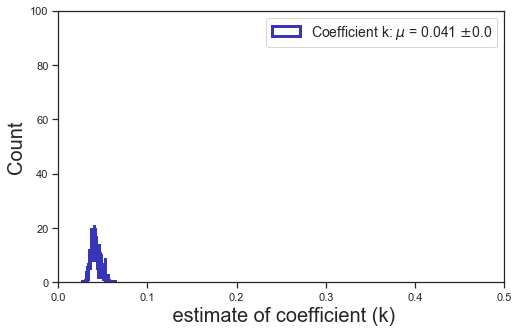

In [21]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (8, 5))
sns.distplot(corrected_k, color = 'xkcd:royal blue', kde = False, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 200)
ax1.set_ylabel('Count', fontsize=20)
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 100)
ax1.set_xlabel(' estimate of coefficient (k)', fontsize = 20)
ax1.legend(['Coefficient k: $\mu$ = '+str(np.round(mean_data_int,3))+' $\pm$'+str(np.round(data_standard_error_int,3))],
           bbox_to_anchor=(0.5, 0.6, 0.5, 0.4),fontsize = 14)
ax1.set_xlim(0, 0.5)

(-1, 2)

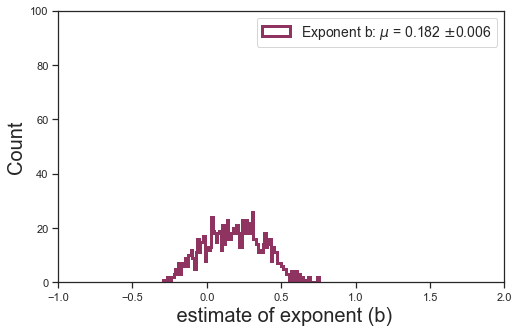

In [22]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (8, 5))
sns.distplot(corrected_b, color = 'xkcd:merlot', kde = False, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 100)
ax1.set_ylabel('Count', fontsize=20)
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 100)
ax1.set_xlabel(' estimate of exponent (b)', fontsize = 20)
ax1.legend(['Exponent b: $\mu$ = '+str(np.round(mean_data,3))+' $\pm$'+str(np.round(data_standard_error,3))],
           bbox_to_anchor=(0.5, 0.6, 0.5, 0.4),fontsize = 14)
ax1.set_xlim(-1, 2)

In [69]:
orthogonal_regression_dataset = all_gully_data

In [70]:
# Initiate some data, giving some randomness using random.random().
x = orthogonal_regression_dataset.loc[:,'log_area'].values
y = orthogonal_regression_dataset.loc[:,'log_slope'].values

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c
   
# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[-0.4, -1])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [-0.09570961 -1.38379316]
Beta Std Error: [0.06078554 0.02584705]
Beta Covariance: [[0.15359627 0.03991436]
 [0.03991436 0.02777168]]
Residual Variance: 0.02405580193131009
Inverse Condition #: 0.31596590141379804
Reason(s) for Halting:
  Sum of squares convergence


In [71]:
b_orth = out.beta[0] 
k_orth = out.beta[1]

In [72]:
k_adjustment_dataset = orthogonal_regression_dataset

In [73]:
target_number_of_points_above_line = np.ceil(len(k_adjustment_dataset)*0.9).astype(int)
adjustment = 0
for u in range(0,100):
    above_model_line = []
    for j in k_adjustment_dataset.index:
        measured_slope = k_adjustment_dataset['log_slope'].loc[j]
        adjusted_intercept = k_orth - adjustment
        model_slope = b_orth * k_adjustment_dataset['log_area'].loc[j] + adjusted_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)                
        else:
            pass
    if len(above_model_line) >= target_number_of_points_above_line:
        break
    else:
        adjustment += 0.01
                

#corrected_set = regression_dataset.drop(above_model_line, axis='index')


In [74]:
exponent_b_to_use = b_orth*-1
scalar_k_to_use = 10**adjusted_intercept

In [75]:
graph_data = orthogonal_regression_dataset

In [76]:
model_parameter_k = scalar_k_to_use
model_parameter_b = exponent_b_to_use

In [77]:
exponent_b = out.beta[0] *-1
coefficient_k = 10**out.beta[1]

print('b: ', exponent_b)
print('k: ', coefficient_k)

b:  0.09570960643047854
k:  0.041324426683118524


In [78]:
generate_area_values = np.arange(0.01, 10, 0.0001)
model_slope = model_parameter_k * (generate_area_values**-model_parameter_b )
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: 'area'}, inplace=True)
graph_data['DC'] = 1
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: 'drainage_slope'}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3
graph_data['Size'] = 500
df_model['Size'] = 1

df_all_1 = df_model.append(graph_data)

No handles with labels found to put in legend.


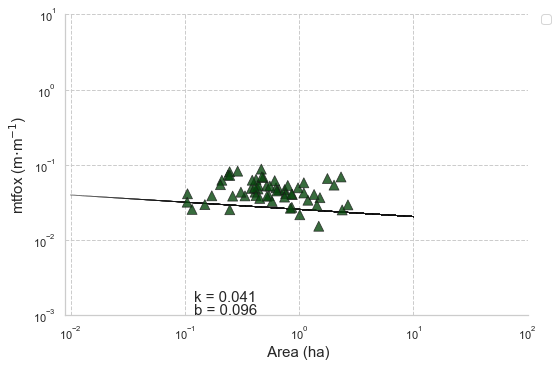

In [79]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_1
colours = {1:'xkcd:forest green', 3:'xkcd:black', 4:'xkcd:forest green'}
x_axis = 'area'
#x_axis_label = x_axis + ' Area (ha)'
x_axis_label = ' Area (ha)'
y_axis = 'drainage_slope'
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.8, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^', '.', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.009, 100))
fig.set(ylim = (0.001, 10))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

#g1 = Line2D([], [], color='xkcd:orange', marker='s', linestyle='None',
#                          markersize=15, label='Gully head 1 (divergent)')

rs = Line2D([], [], color='xkcd:merlot', marker='^', linestyle='None',
                          markersize=15, label='Random sample (convergent)')

#g2 = Line2D([], [], color='xkcd:scarlet', marker='o', linestyle='None',
#                          markersize=15, label='Gully head 2 (divergent)')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('mtfox (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
#plt.legend(handles=[rs, g1, g2],fontsize=13, loc=3)
#plt.legend(handles=[rs],fontsize=13, loc=3)

ax.text(0.12, 0.0015,'k = ' + str(np.round(coefficient_k, 3)), fontsize=15) 
ax.text(0.12, 0.001,'b = ' + str(np.round(exponent_b, 3)), fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(8,5)

In [203]:
slope_area_montecarlo_dict = {}
gully_area = 'area'
gully_slope = 'drainage_slope'
gully_ids = np.array(d['node_id'])
gully_head_list = gully_ids.tolist()
sample_size = 30
whole_dataset = all_data_1m_dataframe
cooks_d_cutoff = 4 / sample_size

for i in range(0,10000):
    sample_number = 'Sample' + str(i)
    all_gully_sample = random.sample(gully_head_list, sample_size)
    all_sample_gullies = pd.DataFrame(all_gully_sample)
    all_sample_gullies.rename(columns={0: 'node_id'}, inplace=True)
    
    all_gully_sample_set = pd.merge(all_sample_gullies, whole_dataset, on=['node_id'], how='inner')
    all_gully_sample_set['log_area'] = np.log10(all_gully_sample_set[gully_area])
    all_gully_sample_set['log_slope'] = np.log10(all_gully_sample_set[gully_slope])

    m = ols('log_area ~ log_slope',all_gully_sample_set).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]
            
    above_model_line = []
    for j in range(0, len(all_gully_sample_set)):
        measured_slope = all_gully_sample_set['log_slope'].iloc[j]
        model_slope = r_slope * all_gully_sample_set['log_area'].iloc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass
    
    corrected_set = all_gully_sample_set.drop(above_model_line, axis='index')
 
    if len(corrected_set) < 3:
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()
        
        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            print(sample_number)

            slope_area_montecarlo_dict[sample_number] = ([slope, intercept])

NameError: name 'd' is not defined

In [ ]:
variance_over_df_conv_b = (np.std(np.array(conv_curve[0]))**2) / len(c_list)
variance_over_df_div_b = (np.std(np.array(div_curve[0]))**2) / len(d_list)
variance_over_df_conv_k = (np.std(np.array(conv_curve[1]))**2) / len(c_list)
variance_over_df_div_k = (np.std(np.array(div_curve[1]))**2) / len(d_list)
denominator_b = np.sqrt(variance_over_df_conv_b + variance_over_df_div_b)
denominator_k = np.sqrt(variance_over_df_conv_k + variance_over_df_div_k)
numerator_b = mean_conv - mean_div
numerator_k = mean_conv_int - mean_div_int
t_value_b = numerator_b / denominator_b
t_value_k = numerator_k / denominator_k